# LIG SST Visualization: Test Version
## Updated Apr 16, Anna Chen

### This is a scrap paper notebook for testing things out

## 04/16 GPT version using EOF (PCA) for HadISST v1.1 modern SST model training

The coordinates of all 86 cores in Hoffman et al.(2017), rounded to the nearest 0.5ºx0.5º, is as follows: 

    Longitude  Latitude
0         6.0      68.0
1       -29.5      65.0
2       -25.0      61.5
3       -14.5      55.5
4       -14.5      55.0
5       -46.0      54.0
6       -20.5      53.5
7       -30.5      53.0
8       -22.0      52.5
9       -23.5      50.0
10       -5.0      45.5
11      -23.5      44.0
12      -10.0      43.0
13      -53.0      42.0
14      -47.5      42.0
15      -33.0      41.0
16      -10.0      40.5
17      -32.0      40.5
18      -10.0      37.5
19      -57.5      33.5
20      -75.5      31.5
21      -87.0      29.0
22      -19.0      27.0
23      -17.0      25.0
24      -94.0      21.5
25      -95.5      20.5
26      -67.0      17.5
27      -19.0      14.0
28      -80.0      11.5
29        9.5       2.5
30      -33.5       1.5
31     -126.5      43.0
32     -126.5      41.0
33     -123.5      37.0
34      142.0      36.0
35     -120.0      34.5
36  

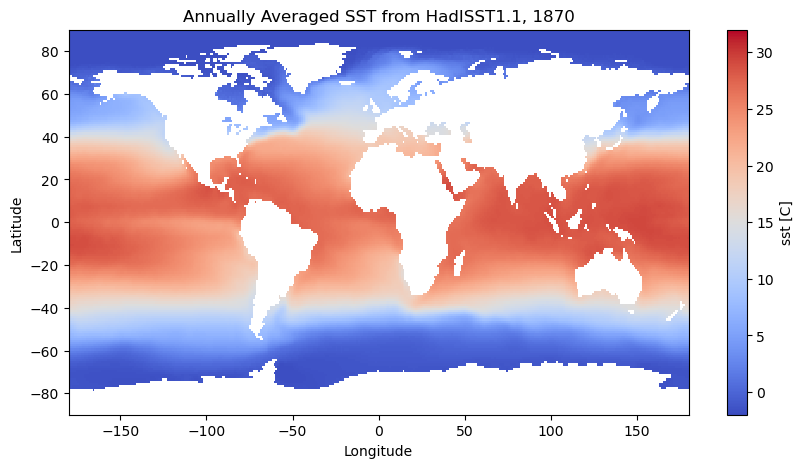

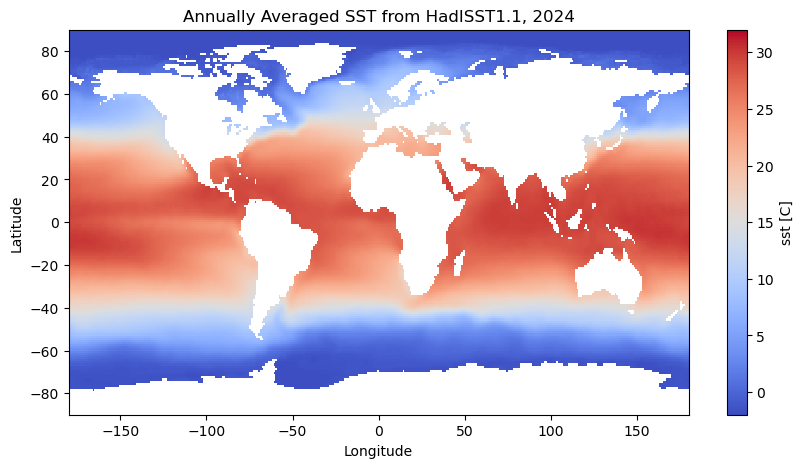

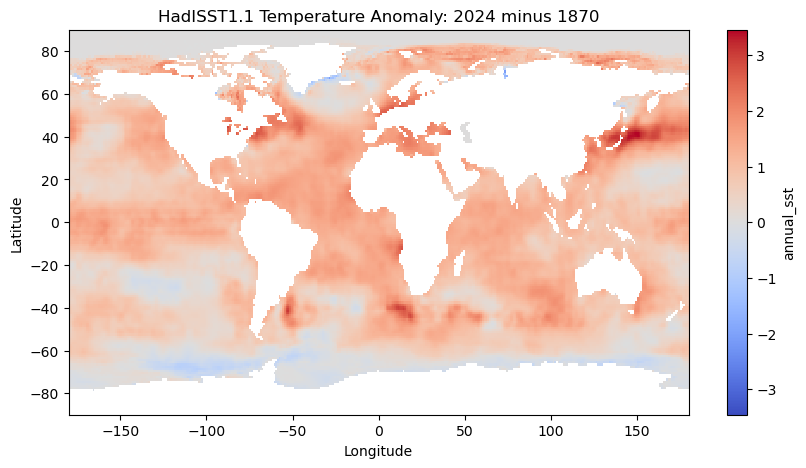

<xarray.Dataset>
Dimensions:     (latitude: 180, longitude: 360, year: 155)
Coordinates:
  * latitude    (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude   (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * year        (year) int64 1870 1871 1872 1873 1874 ... 2021 2022 2023 2024
Data variables:
    annual_sst  (year, latitude, longitude) float32 -1.8 -1.8 -1.8 ... nan nan
After merging with df_coords, total grid points = 3720
After filtering land/sea ice, grid points = 3720
Number of training samples: 2976
Number of testing samples: 744


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import geopandas as gpd
import geodatasets
import netCDF4

import xarray as xr
from scipy.interpolate import griddata

import sys
np.set_printoptions(threshold=sys.maxsize)

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

import warnings
# Filter out warnings from openpyxl regarding unknown extensions.
warnings.filterwarnings("ignore", message="Unknown extension is not supported and will be removed")
# Filter out pyproj warnings regarding converting masked elements to nan.
warnings.filterwarnings("ignore", message="Warning: converting a masked element to nan.")

# Open the Excel file and retrieve sheet names
excel_file = "SST_Hoffman_Harmonized_AC_ES.xlsx"
xls = pd.ExcelFile(excel_file)
sheet_names = xls.sheet_names

# List of sheet names to remove
sheets_to_remove = [
    "Reference Cores Tie Points",
    "Fig1 Global & Regional Stacks",
    "HadSST & SynTrACE Bias Estimate",
    "TEMPLATE",
    "NATL Data Read Me",
    "PAC Data Read Me",
    "IND Data Read Me",
    "SATL Data Read Me"
]

# Remove each sheet in sheets_to_remove if it exists in core_ID_list
for sheet in sheets_to_remove:
    if sheet in sheet_names:
        sheet_names.remove(sheet)

        # Initialize a list to hold (longitude, latitude) tuples.
lon_lat = []

# Loop through every sheet, but only process if not in sheets_to_remove.
for sheet in xls.sheet_names:
    if sheet in sheets_to_remove:
        continue  # Skip sheets in the remove list

    try:
        # Read only columns B and C from the first two rows.
        # Note: Excel row 2 corresponds to index 1 in pandas.
        df_sheet = pd.read_excel(excel_file, sheet_name=sheet, header=None, usecols="B:C", nrows=2)
        
        # Ensure that there are at least two rows in the sheet.
        if df_sheet.shape[0] < 2:
            continue
        
        # Extract longitude from cell B2 and latitude from cell C2.
        lon = df_sheet.iloc[1, 0]
        lat = df_sheet.iloc[1, 1]
        
        # Try converting the values to float; if conversion fails, skip this sheet.
        try:
            lon_val = float(lon)
            lat_val = float(lat)
            lon_lat.append((lon_val, lat_val))
        except (ValueError, TypeError):
            continue  # Skip if conversion to float fails
    except Exception as e:
        print(f"Error processing sheet '{sheet}': {e}")

# Create a DataFrame from the list of tuples.
df_coords = pd.DataFrame(lon_lat, columns=["Longitude", "Latitude"])

# Remove rows that contain any NaN values and any duplicated rows.
df_coords = df_coords.dropna().drop_duplicates().reset_index(drop=True)

# Function to round a number to the nearest 0.5
round_half = lambda x: np.round(x * 2) / 2

# Apply rounding to each column
df_coords['Longitude'] = df_coords['Longitude'].apply(round_half)
df_coords['Latitude'] = df_coords['Latitude'].apply(round_half)

# Clip the rounded values to the allowed ranges
df_coords['Longitude'] = df_coords['Longitude'].clip(lower=-179.5, upper=179.5)
df_coords['Latitude'] = df_coords['Latitude'].clip(lower=-89.5, upper=89.5)

# Display the coordinates from Hoffman 2017
pd.set_option('display.max_rows', None)
print('The coordinates of all 86 cores in Hoffman et al.(2017), rounded to the nearest 0.5ºx0.5º, is as follows:', '\n')
print(df_coords)

# Load netCDF dataset
HadISST = xr.open_dataset('HadISST_sst.nc')

# Clamp SST values: only keep values that are greater than -10.
# Values that are not greater than -10 are replaced with NaN.
HadISST = HadISST.where(HadISST.sst > -10)

# Remove the last time layer (January 2025)
HadISST = HadISST.isel(time=slice(0, -1))

# Verify the time range (optional)
print("Time range:", HadISST.time.min().values, "to", HadISST.time.max().values)

# Group the monthly SST data by the year component of the time coordinate, then average over the time dimension.
# This computes the mean of available months for each year.
HadISST_annual = HadISST.sst.groupby('time.year').mean('time', skipna=True)

# Optionally, convert the resulting DataArray to a Dataset with the variable name 'annual_sst'
HadISST_annual_ds = HadISST_annual.to_dataset(name='annual_sst')

# Check the resulting dataset
print(HadISST_annual_ds)

# Plot the first year (1870) and the last year (2024)

# Plot the first year's SST with a colorbar from -2ºC to 32ºC.
fig, ax = plt.subplots(figsize=(10, 5))
HadISST_annual_ds.annual_sst.sel(year=1870).plot(
    ax=ax, 
    vmin=-2, 
    vmax=32, 
    cmap='coolwarm',
    add_colorbar=True
)
ax.set_title("Annually Averaged SST from HadISST1.1, 1870")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Plot the last year's SST with a colorbar from -2ºC to 32ºC.
fig, ax = plt.subplots(figsize=(10, 5))
HadISST_annual_ds.annual_sst.sel(year=2024).plot(
    ax=ax, 
    vmin=-2, 
    vmax=32, 
    cmap='coolwarm',
    add_colorbar=True
)
ax.set_title("Annually Averaged SST from HadISST1.1, 2024")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Select the first (1870) and last (2024) annual SST layers
sst_1870 = HadISST_annual_ds.annual_sst.sel(year=1870)
sst_2024 = HadISST_annual_ds.annual_sst.sel(year=2024)

# Compute the SST anomaly: difference between 2024 and 1870
sst_anomaly = sst_2024 - sst_1870

# Plot the SST anomaly using the coolwarm colormap
fig, ax = plt.subplots(figsize=(10, 5))
sst_anomaly.plot(
    ax=ax,
    vmin=-5,
    vmax=5,
    cmap='coolwarm',
    add_colorbar=True
)
ax.set_title("HadISST1.1 Temperature Anomaly: 2024 minus 1870")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Convert to a Dataset with variable name 'annual_sst'
HadISST_annual_ds = HadISST_annual.to_dataset(name='annual_sst')
print(HadISST_annual_ds)

# Convert the full annual dataset to a DataFrame.
df_global = HadISST_annual_ds.annual_sst.to_dataframe().reset_index()

# Add coordinate rounding to match df_coords precision
# First round to nearest 0.5 degrees
df_global['latitude'] = np.round(df_global['latitude'] * 2) / 2
df_global['longitude'] = np.round(df_global['longitude'] * 2) / 2

# Clip to valid coordinate ranges
df_global['latitude'] = df_global['latitude'].clip(-89.5, 89.5)
df_global['longitude'] = df_global['longitude'].clip(-179.5, 179.5)

# Prepare df_coords with matching precision
df_coords = df_coords.rename(columns={'Latitude': 'latitude', 'Longitude': 'longitude'})
df_coords['latitude'] = np.round(df_coords['latitude'] * 2) / 2
df_coords['longitude'] = np.round(df_coords['longitude'] * 2) / 2

# Merge with exact coordinate matching
df_subset = pd.merge(df_global, df_coords, on=['latitude', 'longitude'], how='inner')
print("After merging with df_coords, total grid points =", df_subset.shape[0])

# Filter land/sea ice grids
df_subset = df_subset[df_subset['annual_sst'] > -1.8]
print("After filtering land/sea ice, grid points =", df_subset.shape[0])

# Verify we have all 86 locations
assert len(df_subset.groupby(['latitude', 'longitude']).ngroups) == 86, \
    "Mismatch in core locations after rounding and merging"

# --- Create a time–based split ---
# Training data: years that are NOT multiples of 5.
# Testing data: years that ARE multiples of 5.
train_df = df_subset[df_subset['year'] % 5 != 0]
test_df  = df_subset[df_subset['year'] % 5 == 0]

print("Number of training samples:", train_df.shape[0])
print("Number of testing samples:", test_df.shape[0])
if train_df.shape[0] == 0:
    raise ValueError("Training dataset is empty! Check the merge and filtering steps.")

### Debugging: why does df_subset only contain 24 cores when df_coords has 86?

In [88]:
df_subset.shape

(3720, 6)

In [90]:
# Create Cartesian product of all years and core coordinates
all_possible = pd.merge(
    df_coords.assign(key=1),
    df_global[['year']].drop_duplicates().assign(key=1),
    on='key'
).drop('key', axis=1)

# Left merge with actual data
merged_check = pd.merge(all_possible, df_global,
                       on=['year', 'latitude', 'longitude'],
                       how='left',
                       indicator=True)

# Find missing entries where SST is NaN or merge failed
missing_data = merged_check[merged_check['annual_sst'].isna()]

# Group by year and format results
missing_by_year = (
    missing_data.groupby('year')
    .apply(lambda x: list(zip(x.latitude, x.longitude)))
    .to_dict()
)

# Print results
print("Years with missing coordinates in df_global:")
for year, coords in missing_by_year.items():
    print(f"\nYear {year}: {len(coords)} missing coordinates")
    for lat, lon in coords:
        print(f"  ({lat:.1f}, {lon:.1f})")

Years with missing coordinates in df_global:

Year 1870: 2 missing coordinates


TypeError: cannot unpack non-iterable int object

In [91]:
# Isolate 1870 data and merge with core coordinates
df_1870 = df_global[df_global['year'] == 1870].copy()
merged_1870 = pd.merge(df_coords, df_1870,
                      on=['latitude', 'longitude'],
                      how='left',
                      indicator=True)

# Find coordinates with missing SST data
missing_mask = (merged_1870['annual_sst'].isna()) | (merged_1870['_merge'] == 'left_only')
missing_coords_1870 = merged_1870[missing_mask][['latitude', 'longitude']]

# Print results with original coordinate precision
print(f"1870 Missing Coordinates ({len(missing_coords_1870)}/{len(df_coords)}):")
for idx, (lat, lon) in missing_coords_1870.iterrows():
    print(f"  {lat:.1f}°N, {lon:.1f}°E")

1870 Missing Coordinates (62/86):
  68.0°N, 6.0°E
  65.0°N, -29.5°E
  61.5°N, -25.0°E
  55.0°N, -14.5°E
  54.0°N, -46.0°E
  53.0°N, -30.5°E
  52.5°N, -22.0°E
  50.0°N, -23.5°E
  45.5°N, -5.0°E
  44.0°N, -23.5°E
  43.0°N, -10.0°E
  42.0°N, -53.0°E
  42.0°N, -47.5°E
  41.0°N, -33.0°E
  40.5°N, -10.0°E
  40.5°N, -32.0°E
  37.5°N, -10.0°E
  29.0°N, -87.0°E
  27.0°N, -19.0°E
  25.0°N, -17.0°E
  21.5°N, -94.0°E
  17.5°N, -67.0°E
  14.0°N, -19.0°E
  11.5°N, -80.0°E
  43.0°N, -126.5°E
  41.0°N, -126.5°E
  37.0°N, -123.5°E
  36.0°N, 142.0°E
  34.5°N, -120.0°E
  33.0°N, -119.0°E
  23.0°N, -109.5°E
  8.5°N, 110.0°E
  1.0°N, 160.5°E
  1.0°N, -139.0°E
  -3.0°N, -91.0°E
  -3.5°N, -83.0°E
  -23.0°N, 166.0°E
  -40.5°N, 178.0°E
  -40.5°N, -77.0°E
  -42.0°N, -171.5°E
  -45.0°N, 146.5°E
  -45.5°N, 175.0°E
  -45.5°N, 175.0°E
  -48.0°N, 177.5°E
  -48.5°N, 149.0°E
  9.0°N, 90.0°E
  -6.0°N, 103.0°E
  -13.0°N, 122.0°E
  -17.5°N, 118.0°E
  -43.5°N, 51.0°E
  -43.5°N, 80.0°E
  -44.0°N, 51.5°E
  -46.0°N, 96.5°E
 

In [85]:
# Convert coordinates to strings with 1 decimal precision for exact matching
df_global['lat_str'] = df_global['latitude'].round(1).astype(str)
df_global['lon_str'] = df_global['longitude'].round(1).astype(str)
df_coords['lat_str'] = df_coords['latitude'].round(1).astype(str)
df_coords['lon_str'] = df_coords['longitude'].round(1).astype(str)

# Perform merge on string representations
df_subset = pd.merge(
    df_global,
    df_coords[['lat_str', 'lon_str']],
    on=['lat_str', 'lon_str'],
    how='inner'
)

# Filter land/sea ice
df_subset = df_subset[df_subset['annual_sst'] > -1.8]

In [86]:
df_subset.shape

(3720, 6)

In [75]:
# Merge the global dataset with df_coords_round to keep only the 86 grid points.
df_subset = pd.merge(df_global, df_coords, on=['latitude', 'longitude'], how='inner')
print("After merging with df_coords, total grid points =", df_subset.shape[0])

After merging with df_coords, total grid points = 3720


In [76]:
df_global.shape

(10044000, 5)

### From Deepseek: EOF (PCA)

In [19]:
test_matrix = pca_matrix.copy()
#test_matrix[:1]
test_matrix.shape

(155, 43425)

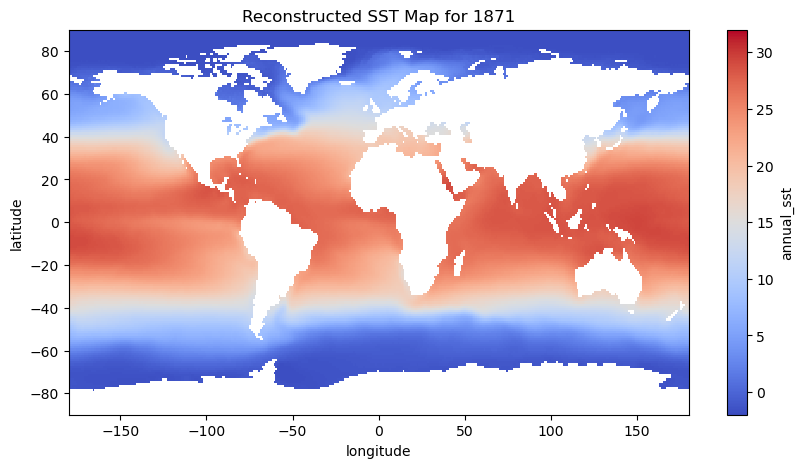

In [8]:
# Step 1: Standardize using global data statistics
valid_sst = df_global['annual_sst'].dropna()
train_mean = valid_sst.mean()
train_std = valid_sst.std()

# Use copy() to avoid SettingWithCopyWarning
df_global = df_global.copy()
train_df = train_df.copy()
test_df = test_df.copy()

for df in [df_global, train_df, test_df]:
    df['sst_std'] = (df['annual_sst'] - train_mean) / train_std

# Step 2: Prepare PCA matrix with imputation
# Create valid ocean mask (grids with data in ANY year)
valid_mask = (~df_global['annual_sst'].isnull()).values.reshape(-1, 180, 360).any(axis=0)
valid_indices = np.where(valid_mask.ravel())[0]

# Create PCA matrix and impute missing values
pca_matrix = df_global['sst_std'].values.reshape(-1, 180*360)[:, valid_indices]

# Impute NaN values with temporal mean for each grid point
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
pca_matrix_imputed = imputer.fit_transform(pca_matrix)

# Step 3: Perform PCA on imputed data
n_components = 20
pca = PCA(n_components=n_components)
pc_scores = pca.fit_transform(pca_matrix_imputed)

# Step 4: Prepare training data for regression model
# Create pivot table for 86-point inputs
train_pivot = train_df.pivot(index='year', 
                            columns=['latitude', 'longitude'], 
                            values='sst_std')

# Find nearest grid indices using vectorized operations
lats = HadISST_annual_ds.latitude.values
lons = HadISST_annual_ds.longitude.values

def find_nearest_index(target, array):
    """Find index of nearest value in array"""
    return np.abs(array - target).argmin()

grid_points = []
for lat, lon in df_coords[['latitude', 'longitude']].values:
    # Find nearest latitude index
    lat_idx = find_nearest_index(lat, lats)
    # Find nearest longitude index
    lon_idx = find_nearest_index(lon, lons)
    grid_points.append(lat_idx * 360 + lon_idx)

# Add validation check
assert len(grid_points) == 86, "Missing grid points in coordinate matching"

# Find positions in valid indices (skipped - prior code)
#input_indices = [np.where(valid_indices == gp)[0][0] for gp in grid_points]

# Step 5: Train regression model (keep original code)
regressor = LinearRegression()
X_train = train_pivot.values
y_train = pc_scores[[np.where(HadISST_annual_ds.year.values == yr)[0][0] 
                   for yr in train_pivot.index]]
regressor.fit(X_train, y_train)

# Step 6: Update reconstruction function with imputation
def reconstruct_sst_map(input_values):
    """Reconstruct full SST map from 86 input values"""
    # Standardize input using TRAINING statistics
    std_values = (input_values - train_mean) / train_std
    
    # Predict PC scores
    pc_pred = regressor.predict([std_values])
    
    # Reconstruct standardized grid WITH IMPUTATION
    recon_std = pca.inverse_transform(pc_pred)[0]
    
    # Create full grid with original NaN patterns
    full_grid = np.full(180*360, np.nan)
    full_grid[valid_indices] = recon_std
    
    # Un-standardize and reshape
    return full_grid.reshape(180, 360) * train_std + train_mean

# Step 7: Generate predictions for all training years
reconstructed_maps = []
for yr in train_df['year'].unique():
    year_data = train_df[train_df['year'] == yr]
    input_values = year_data['annual_sst'].values
    recon_map = reconstruct_sst_map(input_values)
    reconstructed_maps.append((yr, recon_map))

# Convert to xarray Dataset for easy handling
reconstructed_ds = xr.Dataset(
    data_vars={
        'annual_sst': (('year', 'latitude', 'longitude'), 
                      np.array([rm[1] for rm in reconstructed_maps]))
    },
    coords={
        'year': [rm[0] for rm in reconstructed_maps],
        'latitude': HadISST_annual_ds.latitude.values,
        'longitude': HadISST_annual_ds.longitude.values
    }
)

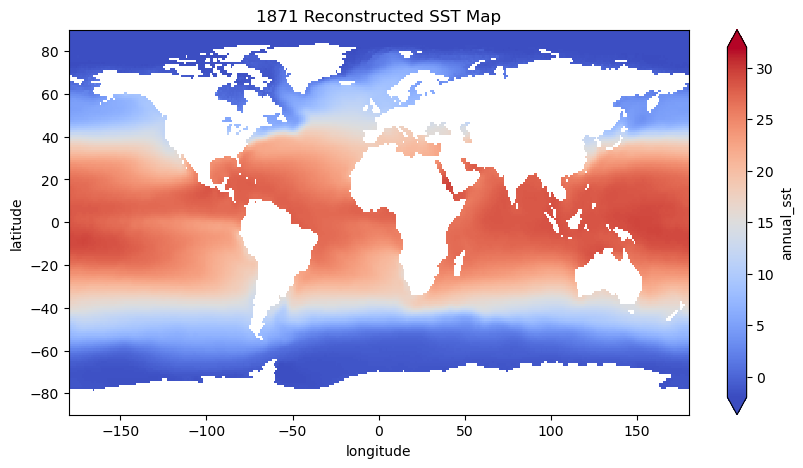

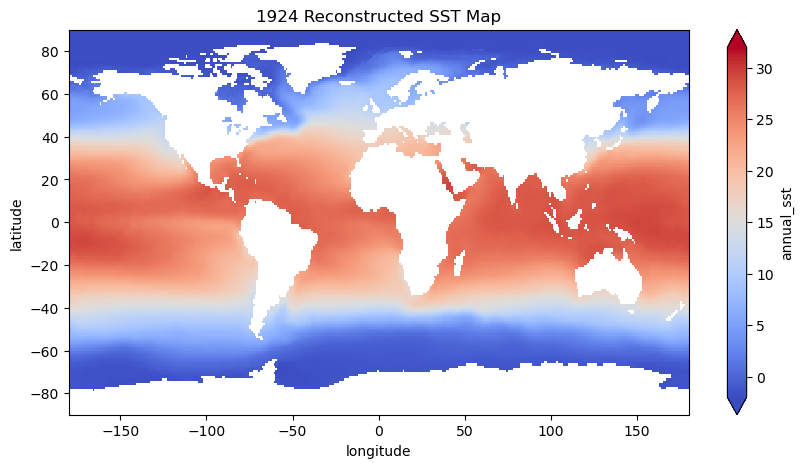

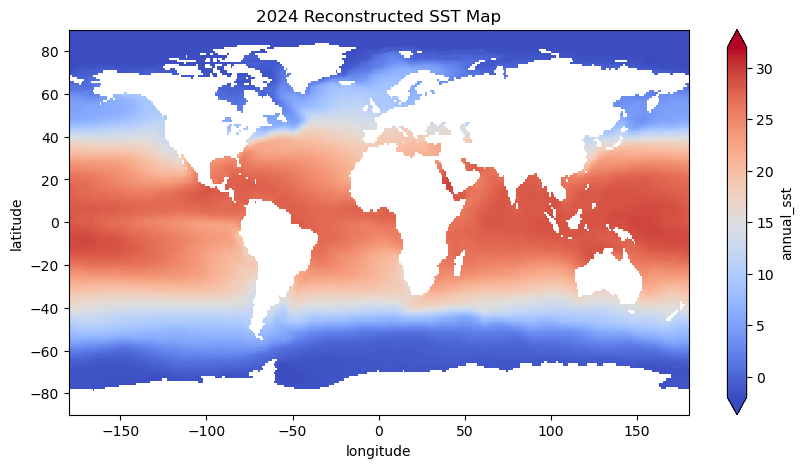

In [35]:
# Plotting reconstructed map
given_year = 1924   # Input any year

for yr in [1871, 1924, 2024]:
    fig, ax = plt.subplots(figsize=(10, 5))
    im = reconstructed_ds.annual_sst.sel(year=given_year).plot(
        ax=ax, cmap='coolwarm', vmin=-2, vmax=32, extend='both'
    )
    
    ax.set_title(f'{yr} Reconstructed SST Map')
    
    plt.show()

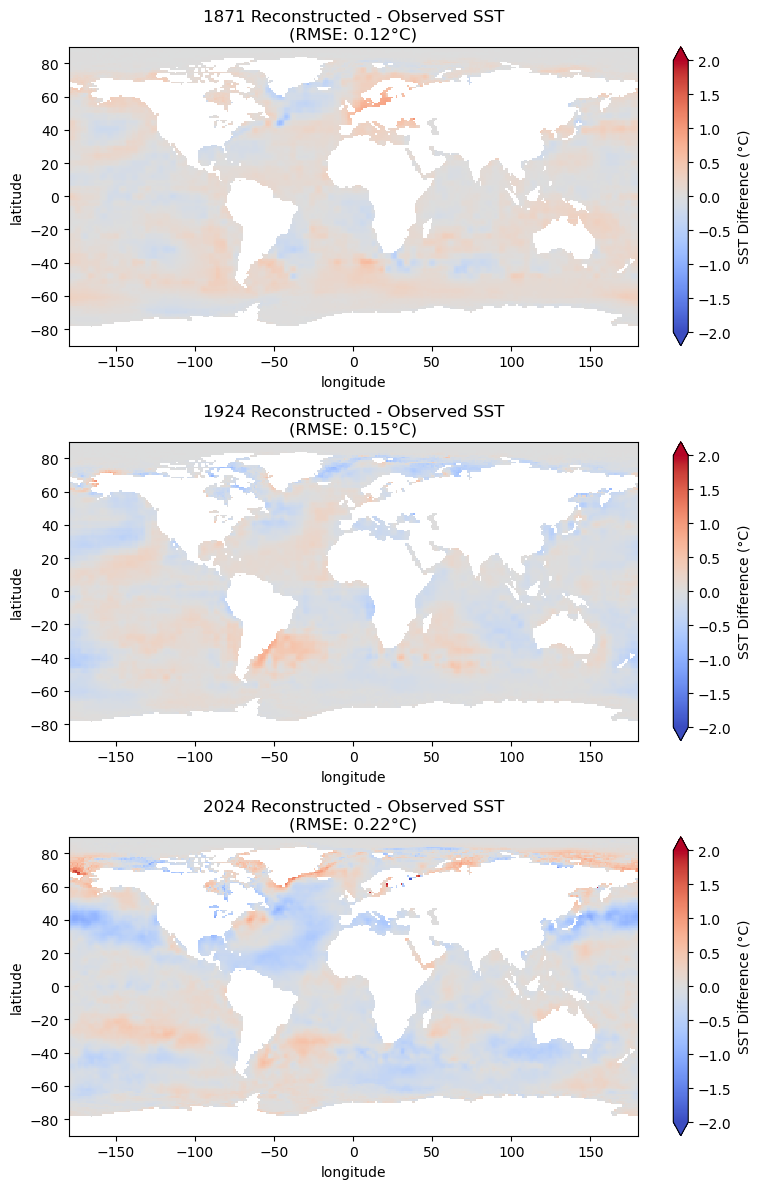

In [29]:
# Convert df_global to xarray Dataset for easy comparison
real_ds = df_global.set_index(['year', 'latitude', 'longitude']).to_xarray().annual_sst

# Create figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Plotting function for difference maps
def plot_difference(ax, year, reconstructed_ds, real_ds):
    """Plot reconstructed - real SST difference for a given year"""
    diff = reconstructed_ds.sel(year=year) - real_ds.sel(year=year)
    
    # Plot with centered colormap
    im = diff.plot(ax=ax, 
                   cmap='coolwarm', 
                   center=0, 
                   vmin=-2, vmax=2,
                   add_colorbar=False)
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='SST Difference (°C)', extend='both')
    ax.set_title(f'{year} Reconstructed - Observed SST\n(RMSE: {diff.std().values:.2f}°C)')

# Plot 1924 difference
plot_difference(axes[0], 1871, reconstructed_ds.annual_sst, real_ds)

# Plot 1924 difference
plot_difference(axes[1], 1924, reconstructed_ds.annual_sst, real_ds)

# Plot 2024 difference
plot_difference(axes[2], 2024, reconstructed_ds.annual_sst, real_ds)

# Final adjustments
plt.tight_layout()
plt.show()

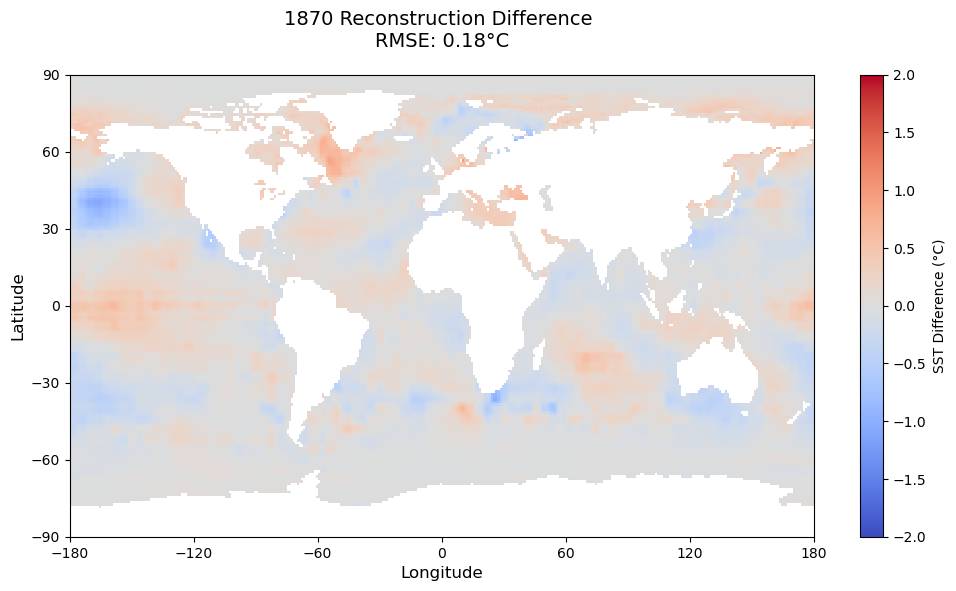

In [54]:
# Calculate and plot 1870 difference
diff_1870 = test_reconstructed_ds.sel(year=1870).annual_sst - real_1870_ds

plt.figure(figsize=(12, 6))

# Create basic plot with xarray's built-in coordinates
diff_1870.plot(cmap='coolwarm', 
              center=0,
              vmin=-2, 
              vmax=2,
              cbar_kwargs={'label': 'SST Difference (°C)'})

# Force longitude/latitude ticks
plt.xticks(np.arange(-180, 181, 60))
plt.yticks(np.arange(-90, 91, 30))

# Add RMSE to title
rmse = np.sqrt((diff_1870**2).mean().values)
plt.title(f"1870 Reconstruction Difference \nRMSE: {rmse:.2f}°C", 
         fontsize=14, pad=20)

plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.show()

In [55]:
# Merge training and test reconstructions
merged_reconstructed_ds = xr.concat(
    [reconstructed_ds, test_reconstructed_ds], 
    dim='year'
).sortby('year')

# Verify the merge
print("Merged dataset years:", merged_reconstructed_ds.year.values)
print("Total years:", len(merged_reconstructed_ds.year))

# Example usage: Access any year's reconstruction
year_1870 = merged_reconstructed_ds.sel(year=1870)
year_2024 = merged_reconstructed_ds.sel(year=2024)

# Full dataset structure
print("\nMerged dataset structure:")
print(merged_reconstructed_ds)

Merged dataset years: [1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883
 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897
 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911
 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925
 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939
 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953
 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967
 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981
 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995
 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009
 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023
 2024]
Total years: 155

Merged dataset structure:
<xarray.Dataset>
Dimensions:     (year: 155, latitude: 180, longitude: 360)
Coordinates:
  * year        (year) int64 1870 1871 1872 1873 1874 ...

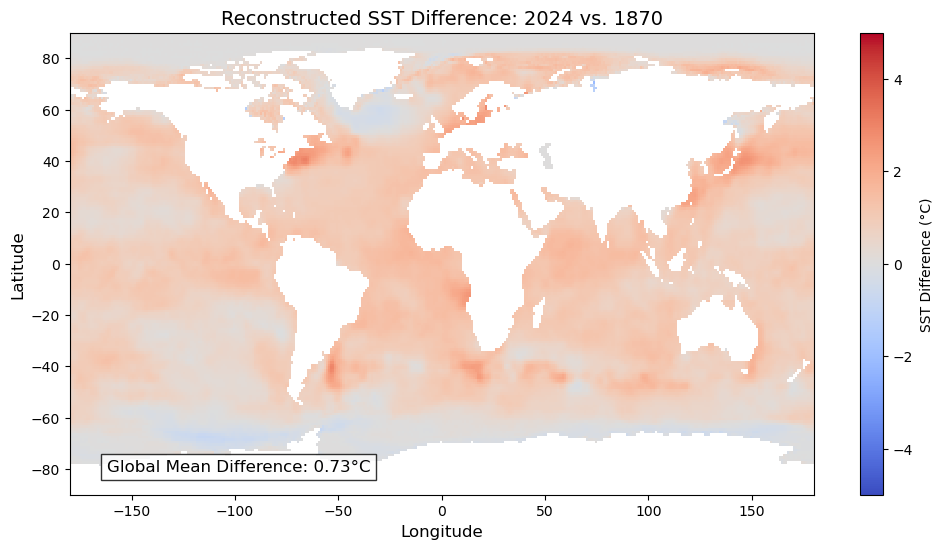

In [58]:
# Calculate the SST anomaly between 2024 and 1870 reconstructions
anomaly = (
    merged_reconstructed_ds.annual_sst.sel(year=2024) 
    - merged_reconstructed_ds.annual_sst.sel(year=1870)
)

# Create plot
plt.figure(figsize=(12, 6))

# Plot anomaly with focused color range
anomaly.plot(cmap='coolwarm',
            center=0,
            vmin=-5, 
            vmax=5,
            cbar_kwargs={'label': 'SST Difference (°C)'})

# Add plot decorations
plt.title('Reconstructed SST Difference: 2024 vs. 1870', fontsize=14)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add statistical annotation
mean_diff = anomaly.mean().values
plt.text(0.05, 0.05, 
        f'Global Mean Difference: {mean_diff:.2f}°C',
        transform=plt.gca().transAxes,
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8))

plt.show()

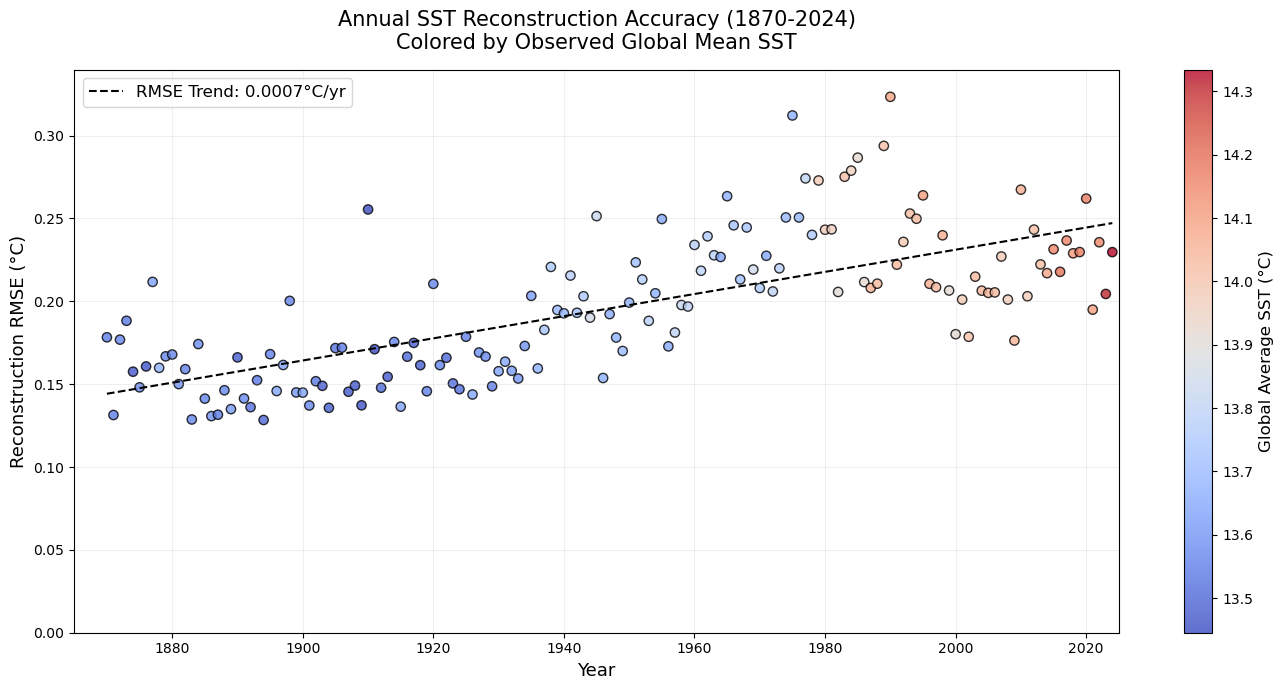

In [60]:
# Calculate annual RMSE and average SST for ALL YEARS
all_years = merged_reconstructed_ds.year.values
rmse_values = []
avg_sst_values = []

for year in all_years:
    # Calculate difference map using merged reconstructions
    diff = merged_reconstructed_ds.sel(year=year).annual_sst - real_ds.sel(year=year)
    
    # Compute RMSE (ocean grids only)
    squared_diff = diff.where(~np.isnan(diff)).values**2
    rmse_values.append(np.sqrt(np.nanmean(squared_diff)))
    
    # Compute global average SST (observed)
    avg_sst = real_ds.sel(year=year).mean().values
    avg_sst_values.append(avg_sst)

# Create figure
plt.figure(figsize=(14, 7))

# Scatter plot colored by average SST
sc = plt.scatter(all_years, rmse_values, c=avg_sst_values, 
                cmap='coolwarm', edgecolor='k', alpha=0.8, s=45,
                vmin=np.min(avg_sst_values), vmax=np.max(avg_sst_values))

# Add colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Global Average SST (°C)', fontsize=12)

# Add trend line for RMSE
z = np.polyfit(all_years, rmse_values, 1)
p = np.poly1d(z)
plt.plot(all_years, p(all_years), 'k--', 
        label=f'RMSE Trend: {z[0]:.4f}°C/yr')

# Formatting
plt.xlabel('Year', fontsize=13)
plt.ylabel('Reconstruction RMSE (°C)', fontsize=13)
plt.title('Annual SST Reconstruction Accuracy (1870-2024)\nColored by Observed Global Mean SST', 
         fontsize=15, pad=15)
plt.grid(alpha=0.2)
plt.legend(fontsize=12)

# Set axis limits
plt.xlim(1865, 2025)
plt.ylim(0, max(rmse_values)*1.05)

plt.tight_layout()
plt.show()

### Century averaged EOFc

In [69]:
# 1. Create century-average from df_subset (86 grids)
century_avg = (
    df_subset[(df_subset['year'] >= 1870) & (df_subset['year'] <= 1970)]
    .groupby(['latitude', 'longitude'])['annual_sst']
    .mean()
    .reset_index()
)

# Verify we have all 86 grids
assert len(century_avg) == 86, "Missing grid points in century average"

# 2. Handle NaNs (if any remain after filtering)
from sklearn.impute import SimpleImputer

# Impute any missing values with column mean
imputer = SimpleImputer(strategy='mean')
X_century = imputer.fit_transform(century_avg[['annual_sst']].values.reshape(1, -1))

# Standardize using original training stats
X_century_std = (X_century - train_mean) / train_std

# Predict and reconstruct
pc_scores_century = regressor.predict(X_century_std)
recon_century = pca.inverse_transform(pc_scores_century)[0]

# Create full grid map
full_grid = np.full(180*360, np.nan)
full_grid[valid_indices] = recon_century * train_std + train_mean
recon_century_map = full_grid.reshape(180, 360)

# Plot
plt.figure(figsize=(10,5))
plt.imshow(recon_century_map, cmap='coolwarm', 
           extent=[-180,180,-90,90], vmin=-2, vmax=30)
plt.colorbar(label='SST (°C)')
plt.title('Century-Averaged Reconstructed SST (1870-1970)')
plt.show()

# 3. Create observed century-average map
obs_century = (
    df_global[(df_global['year'] >= 1870) & (df_global['year'] <= 1970)]
    .groupby(['latitude', 'longitude'])['annual_sst']
    .mean()
    .reset_index()
    .rename(columns={'annual_sst': 'observed_sst'})
)

# Merge with reconstructed data
century_comparison = pd.merge(century_avg, obs_century, 
                             on=['latitude', 'longitude'])

# 4. Analyze anomalies
# Century-scale anomaly
century_diff = recon_century_map - obs_century.set_index(['latitude', 'longitude']).to_xarray().observed_sst.values

# Individual year anomalies
def get_year_anomaly(year):
    recon = merged_reconstructed_ds.sel(year=year).annual_sst.values
    obs = real_ds.sel(year=year).values
    return recon - obs

diff_1870 = get_year_anomaly(1870)
diff_1970 = get_year_anomaly(1970)

# Calculate RMSEs
rmse_century = np.sqrt(np.nanmean(century_diff**2))
rmse_1870 = np.sqrt(np.nanmean(diff_1870**2))
rmse_1970 = np.sqrt(np.nanmean(diff_1970**2))

print(f'''Reconstruction Errors:
- Century Average (1870-1970): {rmse_century:.2f}°C
- Single Year 1870: {rmse_1870:.2f}°C
- Single Year 1970: {rmse_1970:.2f}°C''')

# Visualization of century anomaly
plt.figure(figsize=(10,5))
plt.imshow(century_diff, cmap='coolwarm', 
          extent=[-180,180,-90,90], vmin=-1, vmax=1)
plt.colorbar(label='SST Anomaly (°C)')
plt.title('Century Reconstruction Anomaly (Reconstructed - Observed)')
plt.show()

AssertionError: Missing grid points in century average

In [61]:
# 1. Create century-average of 86 locations (1870-1970)
century_avg = (
    df_global[(df_global['year'] >= 1870) & (df_global['year'] <= 1970)]
    .groupby(['latitude', 'longitude'])['annual_sst']
    .mean()
    .reset_index()
)
century_avg.rename(columns={'annual_sst': 'reconstructed_sst'}, inplace=True)

# 2. Reconstruct global map using existing EOF model
# Prepare input (single "year" of averaged values)
X_century = century_avg['reconstructed_sst'].values.reshape(1, -1)

# Standardize using original global stats
X_century_std = (X_century - train_mean) / train_std


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### From ChatGPT: EOF (PCA)

In [29]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# --- A) Pivot the 86‐point core data into one row per year ----
#   train_df has columns ['year','latitude','longitude','annual_sst']
train_pivot = (
    train_df
    .pivot(index='year', columns=['latitude','longitude'], values='annual_sst')
    # sort the columns so we keep a consistent order of the 86 cores
    .reindex(sorted(train_df[['latitude','longitude']].drop_duplicates().itertuples(index=False, name=None)),
             axis=1)
)
# rename the 86 columns to simple labels
train_pivot.columns = [f"core_{i}" for i in range(train_pivot.shape[1])]
train_pivot = train_pivot.reset_index()   # now columns = ['year','core_0',…,'core_85']

# --- B) Build the regression dataset by merging with df_global ----
# 1) global training rows (all ocean cells in train years)
global_train = df_global[df_global['year'] % 5 != 0].copy()
global_test  = df_global[df_global['year'] % 5 == 0].copy()

# 2) merge so each global row carries along the 86 core values for that year
train_merged = pd.merge(global_train, train_pivot, on='year', how='left')
test_merged  = pd.merge(global_test,  train_pivot, on='year', how='left')

# 3) drop any rows where the join failed (i.e. missing core data)
train_merged = train_merged.dropna(subset=[f"core_{i}" for i in range(86)])
test_merged  = test_merged .dropna(subset=[f"core_{i}" for i in range(86)])

# --- C) Extract X, y for train & test ----
feature_cols = ['year','longitude','latitude'] + [f"core_{i}" for i in range(86)]

X_train = train_merged[feature_cols].values
y_train = train_merged['annual_sst'].values

X_test  = test_merged[feature_cols].values
y_test  = test_merged['annual_sst'].values

# --- D) Scale features, fit Ridge ----
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

reg = Ridge(alpha=1.0)
reg.fit(X_train_scaled, y_train)

# quick eval on held‐out
y_pred = reg.predict(X_test_scaled)
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# --- E) Reconstruct full global maps for each test year ----
# attach predictions
test_merged['sst_pred'] = y_pred

# loop over test years and pivot back to 2D maps
for yr in np.sort(test_merged['year'].unique()):
    sub = test_merged[test_merged['year']==yr]
    # pivot returns a (lat × lon) DataFrame of predictions
    grid_pred = sub.pivot(index='latitude', columns='longitude', values='sst_pred')

    # plot
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': ccrs.PlateCarree()})
    pcm = ax.pcolormesh(
        grid_pred.columns, grid_pred.index, grid_pred.values,
        cmap='coolwarm', vmin=-2, vmax=32,
        transform=ccrs.PlateCarree()
    )
    ax.coastlines()
    ax.set_title(f"Interpolated SST (Ridge) for {yr}")
    plt.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.05)
    plt.show()


KeyError: ['core_24', 'core_25', 'core_26', 'core_27', 'core_28', 'core_29', 'core_30', 'core_31', 'core_32', 'core_33', 'core_34', 'core_35', 'core_36', 'core_37', 'core_38', 'core_39', 'core_40', 'core_41', 'core_42', 'core_43', 'core_44', 'core_45', 'core_46', 'core_47', 'core_48', 'core_49', 'core_50', 'core_51', 'core_52', 'core_53', 'core_54', 'core_55', 'core_56', 'core_57', 'core_58', 'core_59', 'core_60', 'core_61', 'core_62', 'core_63', 'core_64', 'core_65', 'core_66', 'core_67', 'core_68', 'core_69', 'core_70', 'core_71', 'core_72', 'core_73', 'core_74', 'core_75', 'core_76', 'core_77', 'core_78', 'core_79', 'core_80', 'core_81', 'core_82', 'core_83', 'core_84', 'core_85']

### From Deepseek: CNN

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Standardize the SST values
scaler = StandardScaler()

# Fit scaler on all available ocean SST data (excluding NaNs)
all_sst = df_global['annual_sst'].dropna().values.reshape(-1, 1)
scaler.fit(all_sst)

# Apply standardization to all datasets
df_global['annual_sst_std'] = scaler.transform(df_global[['annual_sst']].values)
train_df['annual_sst_std'] = scaler.transform(train_df[['annual_sst']].values)
test_df['annual_sst_std'] = scaler.transform(test_df[['annual_sst']].values)

# 2. Prepare the data for CNN training

# Create a mask for ocean pixels (where SST is not NaN)
ocean_mask = ~np.isnan(HadISST_annual_ds.annual_sst.isel(year=0).values)

# Function to create sparse input maps from the 86 points
def create_sparse_input(year_data, df_coords):
    sparse_map = np.full((180, 360), np.nan)
    for _, row in df_coords.iterrows():
        lat_idx = np.where(HadISST_annual_ds.latitude.values == row['latitude'])[0][0]
        lon_idx = np.where(HadISST_annual_ds.longitude.values == row['longitude'])[0][0]
        # Find the SST value for this location in the given year
        sst_value = year_data[(year_data['latitude'] == row['latitude']) & 
                              (year_data['longitude'] == row['longitude'])]['annual_sst_std'].values
        if len(sst_value) > 0:
            sparse_map[lat_idx, lon_idx] = sst_value[0]
    # Replace remaining NaNs with 0 (will be masked later)
    sparse_map = np.nan_to_num(sparse_map, nan=0)
    return sparse_map

# Prepare training data
X_train = []
y_train = []

for year in train_df['year'].unique():
    year_data = train_df[train_df['year'] == year]
    # Create sparse input (86 points)
    sparse_input = create_sparse_input(year_data, df_coords)
    # Get full target map for this year
    full_map = HadISST_annual_ds.sel(year=year)['annual_sst_std'].values
    full_map = np.nan_to_num(full_map, nan=0)  # Replace NaNs with 0
    
    X_train.append(sparse_input)
    y_train.append(full_map)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Add channel dimension
X_train = X_train[..., np.newaxis]
y_train = y_train[..., np.newaxis]

# Create ocean mask tensor (will be used in loss function)
ocean_mask_tensor = ocean_mask.astype(np.float32)[np.newaxis, ..., np.newaxis]

# 3. Build the CNN model

def build_interpolation_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Bottleneck
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Decoder
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    # Final layer
    outputs = Conv2D(1, (3, 3), activation='linear', padding='same')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

model = build_interpolation_model((180, 360, 1))
model.summary()

# Custom loss function that only considers ocean pixels
def ocean_mse_loss(y_true, y_pred):
    # Calculate squared error
    squared_error = tf.square(y_true - y_pred)
    # Apply ocean mask (only count errors where ocean_mask_tensor == 1)
    masked_error = squared_error * ocean_mask_tensor
    return tf.reduce_mean(masked_error)

# Compile the model
model.compile(optimizer='adam', loss=ocean_mse_loss)

# 4. Train the model
history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=50,
    validation_split=0.2,
    verbose=1
)

# 5. Prepare test data and evaluate
X_test = []
y_test = []
test_years = []

for year in test_df['year'].unique():
    year_data = test_df[test_df['year'] == year]
    sparse_input = create_sparse_input(year_data, df_coords)
    full_map = HadISST_annual_ds.sel(year=year)['annual_sst_std'].values
    full_map = np.nan_to_num(full_map, nan=0)
    
    X_test.append(sparse_input)
    y_test.append(full_map)
    test_years.append(year)

X_test = np.array(X_test)[..., np.newaxis]
y_test = np.array(y_test)[..., np.newaxis]

# Evaluate on test data
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE on ocean pixels): {test_loss:.4f}")

# 6. Function to predict full map from sparse inputs
def predict_full_sst_map(sparse_inputs, model, scaler):
    # Standardize inputs if not already done
    if isinstance(sparse_inputs, pd.DataFrame):
        sparse_inputs['annual_sst_std'] = scaler.transform(sparse_inputs[['annual_sst']].values)
        sparse_map = create_sparse_input(sparse_inputs, df_coords)
    else:
        sparse_map = sparse_inputs
    
    # Add batch and channel dimensions
    sparse_map = np.expand_dims(sparse_map[np.newaxis, ..., np.newaxis], axis=0)
    
    # Predict
    predicted_map_std = model.predict(sparse_map)[0,...,0]
    
    # Inverse transform to get original scale
    predicted_map = scaler.inverse_transform(predicted_map_std.reshape(-1, 1)).reshape(180, 360)
    
    # Apply ocean mask (set land to NaN)
    predicted_map[~ocean_mask] = np.nan
    
    return predicted_map

# Example usage on a test year
example_year = test_years[0]
example_data = test_df[test_df['year'] == example_year]
predicted_map = predict_full_sst_map(example_data, model, scaler)

# Compare with true map
true_map = HadISST_annual_ds.sel(year=example_year)['annual_sst'].values

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
true_map_plot = ax1.imshow(true_map, cmap='coolwarm', vmin=-2, vmax=32)
ax1.set_title(f"True SST Map {example_year}")
fig.colorbar(true_map_plot, ax=ax1)

pred_map_plot = ax2.imshow(predicted_map, cmap='coolwarm', vmin=-2, vmax=32)
ax2.set_title(f"Predicted SST Map {example_year}")
fig.colorbar(pred_map_plot, ax=ax2)
plt.show()

/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_90444/709873490.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['annual_sst_std'] = scaler.transform(train_df[['annual_sst']].values)
/var/folders/z1/qxyx9p114qn5g8pjhv3f78j40000gn/T/ipykernel_90444/709873490.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['annual_sst_std'] = scaler.transform(test_df[['annual_sst']].values)


IndexError: index 0 is out of bounds for axis 0 with size 0